In [1]:
from __future__ import division, print_function
%matplotlib inline
from importlib import reload  # Python 3
import utils; reload(utils)
from utils import *
from keras.layers.merge import dot, add, concatenate

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)
Using TensorFlow backend.


In [2]:
#path = "data/ml-latest-small/"  # from https://grouplens.org/datasets/movielens/
#path = "data/ml-20m/"
path = "datas/movielens/" #from https://github.com/ChicagoBoothML/DATA___MovieLens___20M
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

batch_size=64
#batch_size=1

In [3]:
#20M dataset
#ratings = pd.read_csv(path+'ratings.csv')

#2M dataset
#ratings = pd.read_csv(path+'ratings01.csv')

#100k dataset
ratings = pd.read_csv(path+'ratings100k.csv')

In [4]:
#show 5 first file rows
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [5]:
#nb of lines
len(ratings)

100000

## datas prep
1. read files : ratings + movies
1. get list of unique items in ratings : users ID & movies ID
1. reorder users ID & movies ID to have countinuous integer items

In [6]:
#read film names
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict

#https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python
#https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_dict.html
#https://stackoverflow.com/questions/30060616/python-pandas-to-dict-function

In [7]:
movie_names1 = pd.read_csv(path+'movies.csv').set_index('movieId')['title']
print(movie_names1[:5])

movieId
1                      Toy Story (1995)
2                        Jumanji (1995)
3               Grumpier Old Men (1995)
4              Waiting to Exhale (1995)
5    Father of the Bride Part II (1995)
Name: title, dtype: object


In [8]:
movie_names2 = pd.read_csv(path+'movies.csv').set_index('movieId')
print(movie_names2[:5])

                                      title  \
movieId                                       
1                          Toy Story (1995)   
2                            Jumanji (1995)   
3                   Grumpier Old Men (1995)   
4                  Waiting to Exhale (1995)   
5        Father of the Bride Part II (1995)   

                                              genres  
movieId                                               
1        Adventure|Animation|Children|Comedy|Fantasy  
2                         Adventure|Children|Fantasy  
3                                     Comedy|Romance  
4                               Comedy|Drama|Romance  
5                                             Comedy  


In [9]:
usersUniq = ratings.userId.unique()
moviesUniq = ratings.movieId.unique()

print(usersUniq[:20])
print(moviesUniq[:20])

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[  2  29  32  47  50 112 151 223 253 260 293 296 318 337 367 541 589 593 653 919]


In [10]:
# userId and movieId become ditionary elements with values ranging from 0 to max len 
userUniqID2idx = {userID:index for index,userID in enumerate(usersUniq)}
movieUniqID2idx = {movieID:index for index,movieID in enumerate(moviesUniq)}

In [11]:
{movieID : movieUniqID2idx[movieID] for movieID in list(movieUniqID2idx)[:10]}

{1: 227,
 2: 0,
 3: 175,
 4: 1994,
 5: 1044,
 6: 364,
 7: 420,
 8: 1965,
 9: 1677,
 10: 365}

In [12]:
ratings.movieId[:20]

0       2
1      29
2      32
3      47
4      50
5     112
6     151
7     223
8     253
9     260
10    293
11    296
12    318
13    337
14    367
15    541
16    589
17    593
18    653
19    919
Name: movieId, dtype: int64

In [13]:
#We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.
ratings.movieId = ratings.movieId.apply(lambda x: movieUniqID2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userUniqID2idx[x])

#https://chrisalbon.com/python/data_wrangling/pandas_apply_operations_to_dataframes/

In [14]:
ratings.movieId[:15]

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
Name: movieId, dtype: int64

In [15]:
ratings.movieId[200:220]

200    192
201    193
202    194
203    195
204    196
205    197
206    198
207    199
208    200
209    201
210     80
211    202
212    203
213    204
214    205
215    206
216    207
217    208
218    209
219    210
Name: movieId, dtype: int64

In [16]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())

In [17]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()

In [18]:
user_min, user_max, movie_min, movie_max, n_users, n_movies

(0, 701, 0, 8226, 702, 8227)

### embeddings

In [19]:
#number of latent factors in each embedding
n_factors = 50

In [20]:
np.random.seed = 42

#https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.seed.html

In [21]:
#Randomly split into training and validation

#Create an array of the given shape and populate it with random samples from a uniform distribution over [0, 1).
msk = np.random.rand(len(ratings)) < 0.8
print(msk)

trn = ratings[msk]
val = ratings[~msk]

[ True False  True ...,  True False False]


In [22]:
trn[:5]

,userId,movieId,rating,timestamp
0,0,0,3.5,1112486027
2,0,2,3.5,1112484819
5,0,5,3.5,1094785740
6,0,6,4.0,1094785734
8,0,8,4.0,1112484940


In [23]:
val[:5]

,userId,movieId,rating,timestamp
1,0,1,3.5,1112484676
3,0,3,3.5,1112484727
4,0,4,3.5,1112484580
7,0,7,4.0,1112485573
10,0,10,4.0,1112484703


### Dot product
The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

latent factor = explicative variables
#### calculate the latent factors for each movie AND each user, so that we can predict ratings by a dot product of 2 vectors :
latent user factors vector * latent movie factors vector

In [24]:
user_min, user_max, movie_min, movie_max, n_users, n_movies, n_factors

(0, 701, 0, 8226, 702, 8227, 50)

In [25]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(input_dim=n_in, output_dim=n_out, input_length=1, embeddings_regularizer=l2(reg))(inp)

In [26]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [27]:
u

<tf.Tensor 'embedding_1/Gather:0' shape=(?, 1, 50) dtype=float32>

In [28]:
#model construction, no data yet (we love TF :D)
x = dot([u, m], axes=2)
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [29]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, epochs=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80181 samples, validate on 19819 samples
Epoch 1/1
80181/80181 [==============================] - 6s - loss: 9.7462 - val_loss: 4.2254


In [30]:
model.optimizer.lr=0.01

In [31]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, epochs=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80181 samples, validate on 19819 samples
Epoch 1/3
80181/80181 [==============================] - 6s - loss: 3.0511 - val_loss: 2.7293
Epoch 2/3
80181/80181 [==============================] - 6s - loss: 2.3381 - val_loss: 2.5222
Epoch 3/3
80181/80181 [==============================] - 6s - loss: 2.1791 - val_loss: 2.4669


In [32]:
model.optimizer.lr=0.001

In [33]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, epochs=4, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80181 samples, validate on 19819 samples
Epoch 1/4
80181/80181 [==============================] - 6s - loss: 2.1194 - val_loss: 2.4578
Epoch 2/4
80181/80181 [==============================] - 6s - loss: 2.0864 - val_loss: 2.4580
Epoch 3/4
80181/80181 [==============================] - 6s - loss: 2.0639 - val_loss: 2.4595
Epoch 4/4
80181/80181 [==============================] - 6s - loss: 2.0442 - val_loss: 2.4636


In [34]:
#best result at epoch 3 !

### add Bias
The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [35]:
def create_bias(inp, n_in):
    x = Embedding(input_dim=n_in, output_dim=1, input_length=1)(inp)
    return Flatten()(x)

In [36]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [37]:
x = dot([u, m], axes=2)
x = Flatten()(x)
x = add([x, ub])
x = add([x, mb])
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [38]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, epochs=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80181 samples, validate on 19819 samples
Epoch 1/1
80181/80181 [==============================] - 8s - loss: 2.8788 - val_loss: 2.5376


In [39]:
model.optimizer.lr=0.001

In [40]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, epochs=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80181 samples, validate on 19819 samples
Epoch 1/10
80181/80181 [==============================] - 7s - loss: 2.1035 - val_loss: 2.2432
Epoch 2/10
80181/80181 [==============================] - 7s - loss: 1.8792 - val_loss: 2.1356
Epoch 3/10
80181/80181 [==============================] - 7s - loss: 1.7708 - val_loss: 2.0623
Epoch 4/10
80181/80181 [==============================] - 7s - loss: 1.6931 - val_loss: 2.0036
Epoch 5/10
80181/80181 [==============================] - 7s - loss: 1.6247 - val_loss: 1.9361
Epoch 6/10
80181/80181 [==============================] - 7s - loss: 1.5596 - val_loss: 1.8871
Epoch 7/10
80181/80181 [==============================] - 7s - loss: 1.4958 - val_loss: 1.8286
Epoch 8/10
80181/80181 [==============================] - 7s - loss: 1.4341 - val_loss: 1.7712
Epoch 9/10
80181/80181 [==============================] - 7s - loss: 1.3724 - val_loss: 1.7176
Epoch 10/10
80181/80181 [==============================] - 7s - loss: 1.3131 - val_loss: 1.6634

In [41]:
model.save_weights(model_path+'bias.h5')

In [42]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, epochs=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80181 samples, validate on 19819 samples
Epoch 1/5
80181/80181 [==============================] - 7s - loss: 1.2557 - val_loss: 1.6168
Epoch 2/5
80181/80181 [==============================] - 7s - loss: 1.2009 - val_loss: 1.5671
Epoch 3/5
80181/80181 [==============================] - 7s - loss: 1.1464 - val_loss: 1.5212
Epoch 4/5
80181/80181 [==============================] - 7s - loss: 1.0958 - val_loss: 1.4814
Epoch 5/5
80181/80181 [==============================] - 7s - loss: 1.0466 - val_loss: 1.4386


In [43]:
model.save_weights(model_path+'bias.h5')

In [44]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, epochs=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80181 samples, validate on 19819 samples
Epoch 1/5
80181/80181 [==============================] - 7s - loss: 0.9999 - val_loss: 1.4001
Epoch 2/5
80181/80181 [==============================] - 7s - loss: 0.9567 - val_loss: 1.3639
Epoch 3/5
80181/80181 [==============================] - 7s - loss: 0.9143 - val_loss: 1.3288
Epoch 4/5
80181/80181 [==============================] - 7s - loss: 0.8758 - val_loss: 1.2924
Epoch 5/5
80181/80181 [==============================] - 7s - loss: 0.8392 - val_loss: 1.2596


In [45]:
model.save_weights(model_path+'bias.h5')

In [46]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, epochs=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80181 samples, validate on 19819 samples
Epoch 1/5
80181/80181 [==============================] - 8s - loss: 0.8056 - val_loss: 1.2320
Epoch 2/5
80181/80181 [==============================] - 7s - loss: 0.7742 - val_loss: 1.2056
Epoch 3/5
80181/80181 [==============================] - 7s - loss: 0.7455 - val_loss: 1.1815
Epoch 4/5
80181/80181 [==============================] - 7s - loss: 0.7195 - val_loss: 1.1585
Epoch 5/5
80181/80181 [==============================] - 7s - loss: 0.6961 - val_loss: 1.1386


In [47]:
model.save_weights(model_path+'bias.h5')

In [51]:
#df.loc[(df['column_name'] == some_value) & df['other_column'].isin(some_values)]
val.loc[(ratings['userId'] == 10) & (t['movieId'] < 500)]
#t.loc[(t['movieId'] < 500)] 

,userId,movieId,rating,timestamp
968,10,392,5.0,1230785343
985,10,12,5.0,1230850571
987,10,369,5.0,1230858804
997,10,182,5.0,1230788713
1022,10,414,5.0,1251170912
1037,10,251,5.0,1230853696
1051,10,36,3.0,1230785513
1068,10,191,5.0,1230788734
1072,10,287,4.5,1230789404
1076,10,193,5.0,1230788594


In [52]:
#predict how much user 'X' would rate movie 'X'
model.predict([np.array([10]), np.array([12])])

array([[ 4.7766]], dtype=float32)

In [53]:
model.predict([np.array([10]), np.array([36])])

array([[ 4.3555]], dtype=float32)

## analyse results
To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [54]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

In [75]:
g.head()

movieId
0    112
1     43
2    220
3    214
4    224
Name: rating, dtype: int64

In [55]:
topMovies

array([  11,  369,   12, ..., 3496, 1674, 2605])

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [60]:
get_movie_bias = Model(movie_in, mb)
get_movie_bias

In [62]:
movie_bias = get_movie_bias.predict(topMovies)
movie_bias

array([[ 0.9288],
       [ 1.0704],
       [ 1.2326],
       ..., 
       [ 0.6396],
       [ 0.9626],
       [ 1.1562]], dtype=float32)

In [70]:
movie_ratings = [(b[0], movie_names()[moviesUniq[i]]) for i,b in zip(topMovies,movie_bias)]

In [71]:
movie_ratings[:20]

[(0.92878383, 'Pulp Fiction (1994)'),
 (1.0703554, 'Forrest Gump (1994)'),
 (1.2325772, 'Shawshank Redemption, The (1994)'),
 (0.79887098, 'Jurassic Park (1993)'),
 (1.0526571, 'Silence of the Lambs, The (1991)'),
 (1.0540749, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.81992704, 'Braveheart (1995)'),
 (1.0327945, 'Terminator 2: Judgment Day (1991)'),
 (0.89428252, 'Matrix, The (1999)'),
 (1.3018008, "Schindler's List (1993)"),
 (1.031371, 'Toy Story (1995)'),
 (0.90807498, 'American Beauty (1999)'),
 (0.99431068, 'Apollo 13 (1995)'),
 (0.69766098, 'Independence Day (a.k.a. ID4) (1996)'),
 (1.0305663, 'Fugitive, The (1993)'),
 (0.84989733, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (0.89199877, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (1.0085971, 'Fargo (1996)'),
 (0.83523244, 'True Lies (1994)'),
 (1.2214942, 'Usual Suspects, The (1995)')]

    #Zip the 2 lists together into one list of (key,value) tuples: zipped  
    zipped = list(zip(list_keys, list_values))

    #Inspect the list using print()  
    print(zipped)

    #Build a dictionary with the zipped list: data  
    data = dict(zipped)

    #Build and inspect a DataFrame from the dictionary: df  
    df = pd.DataFrame(data)  
    print(df)  

    script output:  
    [('Country', ['United States', 'Soviet Union', 'United Kingdom']), ('Total', [1118, 473, 273])]  
              Country  Total  
    0   United States   1118  
    1    Soviet Union    473  
    2  United Kingdom    273  
    

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [72]:
#ascending sort over col 0 (movie bias)
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.21169831, 'Spice World (1997)'),
 (-0.20490177, 'Battlefield Earth (2000)'),
 (-0.19969521, 'Speed 2: Cruise Control (1997)'),
 (-0.12189711, 'Police Academy 6: City Under Siege (1989)'),
 (-0.1193466, 'Stop! Or My Mom Will Shoot (1992)'),
 (-0.085184649, 'Rocky V (1990)'),
 (-0.046443973, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.039057478, 'Super Mario Bros. (1993)'),
 (0.024995308, 'Bio-Dome (1996)'),
 (0.028333437, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)'),
 (0.033624347, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (0.065969169, 'Rambo III (1988)'),
 (0.069317624, 'Attack of the Killer Tomatoes! (1978)'),
 (0.071688548, "Look Who's Talking Too (1990)"),
 (0.072256155, 'Nightmare on Elm Street 4: The Dream Master, A (1988)')]

In [73]:
#descending sort ovel col 0
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.7052077, 'Man Who Would Be King, The (1975)'),
 (1.5323569, 'Before Sunset (2004)'),
 (1.5251349, 'Whale Rider (2002)'),
 (1.5045266,
  'Bicycle Thieves (a.k.a. The Bicycle Thief) (a.k.a. The Bicycle Thieves) (Ladri di biciclette) (1948)'),
 (1.4959528, 'Dark Knight Rises, The (2012)'),
 (1.4871119,
  'Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984)'),
 (1.4777347, 'Cold Comfort Farm (1995)'),
 (1.4759152, 'Wallace & Gromit: A Close Shave (1995)'),
 (1.471267, 'Forgetting Sarah Marshall (2008)'),
 (1.4700413, 'Thin Blue Line, The (1988)'),
 (1.4525245, 'Charade (1963)'),
 (1.4525008, 'Flirting With Disaster (1996)'),
 (1.4516518, 'Roman Holiday (1953)'),
 (1.4452684, 'My Life in Pink (Ma vie en rose) (1997)'),
 (1.4409863, 'Bourne Ultimatum, The (2007)')]

We can now do the same thing for the embeddings.

In [78]:
#get_movie_bias = Model(movie_in, mb)
get_movie_emb = Model(movie_in, m)
get_movie_emb.predict([topMovies]).shape

(2000, 1, 50)

numpy.squeeze(a, axis=None): Remove single-dimensional entries from the shape of an array.  

    >>> x = np.array([[[0], [1], [2]]])
    >>> x.shape
    (1, 3, 1)
    >>> np.squeeze(x).shape
    (3,)

In [79]:
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use PCA to simplify them down to just 3 vectors.

In [80]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [81]:
fac0 = movie_pca[0]

In [83]:
movie_comp = [(f, movie_names()[moviesUniq[i]]) for f,i in zip(fac0, topMovies)]

In [84]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.012324488, 'Nightmare on Elm Street 4: The Dream Master, A (1988)'),
 (0.010345526, "Dante's Peak (1997)"),
 (0.0098992391, 'Nutty Professor, The (1963)'),
 (0.0097711366, 'Bio-Dome (1996)'),
 (0.009566959, 'Speed 2: Cruise Control (1997)'),
 (0.0090712626, 'Deuce Bigalow: Male Gigolo (1999)'),
 (0.0085764388, 'Wanted (2008)'),
 (0.0085288687, 'Showgirls (1995)'),
 (0.0083166128, 'Haunting, The (1999)'),
 (0.0082856473, 'Popeye (1980)')]

In [85]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.068805255, 'Shawshank Redemption, The (1994)'),
 (-0.064697586, 'Pulp Fiction (1994)'),
 (-0.064116918,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (-0.063728593, 'Matrix, The (1999)'),
 (-0.063326113, 'Seven (a.k.a. Se7en) (1995)'),
 (-0.062851653, 'Monty Python and the Holy Grail (1975)'),
 (-0.060301252, 'Braveheart (1995)'),
 (-0.05880329, "Schindler's List (1993)"),
 (-0.058468714, 'Silence of the Lambs, The (1991)'),
 (-0.057920702, 'Indiana Jones and the Last Crusade (1989)')]

In [86]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names()[moviesUniq[i]]) for f,i in zip(fac1, topMovies)]

In [87]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.08966931, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.081097409, 'Net, The (1995)'),
 (0.078878231, 'Pretty Woman (1990)'),
 (0.078310929, "Mr. Holland's Opus (1995)"),
 (0.077387378, 'Jurassic Park (1993)'),
 (0.077009939, 'Armageddon (1998)'),
 (0.07432387, 'Ghost (1990)'),
 (0.074114785, 'Apollo 13 (1995)'),
 (0.072883576, 'While You Were Sleeping (1995)'),
 (0.072442569, 'Mrs. Doubtfire (1993)')]

In [88]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.072277427, 'Rushmore (1998)'),
 (-0.070563741, 'Clockwork Orange, A (1971)'),
 (-0.069745101, 'Pulp Fiction (1994)'),
 (-0.066586919, 'Annie Hall (1977)'),
 (-0.06503471, '2001: A Space Odyssey (1968)'),
 (-0.064997949, 'Being John Malkovich (1999)'),
 (-0.06347727, 'Election (1999)'),
 (-0.062235117, 'Apocalypse Now (1979)'),
 (-0.06061789, 'Raging Bull (1980)'),
 (-0.057877157, 'Donnie Darko (2001)')]

In [89]:
fac2 = movie_pca[2]
movie_comp = [(f, movie_names()[moviesUniq[i]]) for f,i in zip(fac2, topMovies)]

In [90]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.10274497, 'Matrix, The (1999)'),
 (0.094787553, 'Pulp Fiction (1994)'),
 (0.091029361, 'From Dusk Till Dawn (1996)'),
 (0.089531332, 'Boondock Saints, The (2000)'),
 (0.087431177, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (0.086944476, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.08232379, '300 (2007)'),
 (0.080956571, 'Reservoir Dogs (1992)'),
 (0.079960302, 'Fight Club (1999)'),
 (0.073560551, 'Aliens (1986)')]

In [91]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.10597292, 'Babe (1995)'),
 (-0.092798211, "Mr. Holland's Opus (1995)"),
 (-0.082543209, '101 Dalmatians (1996)'),
 (-0.075114056, 'While You Were Sleeping (1995)'),
 (-0.073135488, 'Ghost (1990)'),
 (-0.071305983, 'Mrs. Doubtfire (1993)'),
 (-0.067589976, 'Sleepless in Seattle (1993)'),
 (-0.066678561, 'Crying Game, The (1992)'),
 (-0.066116907, 'Willy Wonka & the Chocolate Factory (1971)'),
 (-0.064342707, 'Net, The (1995)')]

In [92]:
#We can draw a picture to see how various movies appear on the map of these components. 

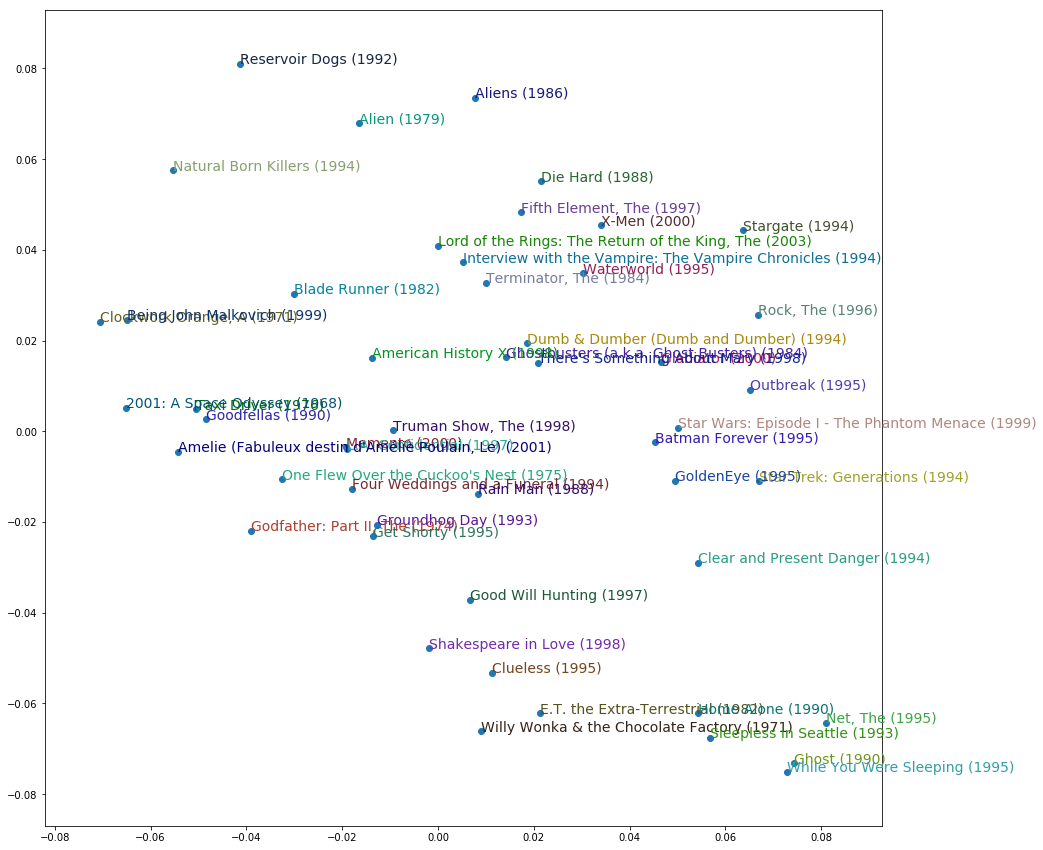

In [96]:
#This picture shows the 1st and 3rd components.
# 'violent vs happy' & ???
start=50; end=100
X = fac1[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names()[moviesUniq[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

### Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [97]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [98]:
x = concatenate([u, m], axis=2)
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [99]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=8, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80181 samples, validate on 19819 samples
Epoch 1/8
80181/80181 [==============================] - 8s - loss: 2.4796 - val_loss: 0.9272
Epoch 2/8
80181/80181 [==============================] - 8s - loss: 1.4740 - val_loss: 0.8952
Epoch 3/8
80181/80181 [==============================] - 8s - loss: 1.2487 - val_loss: 0.8865
Epoch 4/8
80181/80181 [==============================] - 8s - loss: 1.0491 - val_loss: 0.8736
Epoch 5/8
80181/80181 [==============================] - 8s - loss: 0.9293 - val_loss: 0.8693
Epoch 6/8
80181/80181 [==============================] - 8s - loss: 0.8678 - val_loss: 0.8552
Epoch 7/8
80181/80181 [==============================] - 8s - loss: 0.8390 - val_loss: 0.8551
Epoch 8/8
80181/80181 [==============================] - 8s - loss: 0.8308 - val_loss: 0.8549


In [100]:
val.loc[(ratings['userId'] == 10) & (t['movieId'] < 500)]

,userId,movieId,rating,timestamp
968,10,392,5.0,1230785343
985,10,12,5.0,1230850571
987,10,369,5.0,1230858804
997,10,182,5.0,1230788713
1022,10,414,5.0,1251170912
1037,10,251,5.0,1230853696
1051,10,36,3.0,1230785513
1068,10,191,5.0,1230788734
1072,10,287,4.5,1230789404
1076,10,193,5.0,1230788594


In [102]:
nn.predict([np.array([10]), np.array([12])])

array([[ 4.7529]], dtype=float32)

In [103]:
nn.predict([np.array([10]), np.array([36])])

array([[ 4.1746]], dtype=float32)

In [104]:
get_movie_emb2 = Model(movie_in, m)
movie_emb2 = np.squeeze(get_movie_emb2.predict([topMovies]))
movie_emb2.shape

(2000, 50)

In [105]:
pca2 = PCA(n_components=3)
movie_pca2 = pca2.fit(movie_emb2.T).components_

In [110]:
fac20 = movie_pca2[0]
movie_comp2 = [(f, movie_names()[moviesUniq[i]]) for f,i in zip(fac20, topMovies)]

In [111]:
sorted(movie_comp2, key=itemgetter(0), reverse=True)[:10]

[(0.070669286, 'Shawshank Redemption, The (1994)'),
 (0.060036138, 'Godfather, The (1972)'),
 (0.05989024, 'Usual Suspects, The (1995)'),
 (0.058383279, 'City of God (Cidade de Deus) (2002)'),
 (0.056411639, 'Dark Knight, The (2008)'),
 (0.055232123, 'Before Sunset (2004)'),
 (0.054760192, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (0.0543392, 'Dark Knight Rises, The (2012)'),
 (0.054216966, "One Flew Over the Cuckoo's Nest (1975)"),
 (0.053290375, 'Godfather: Part II, The (1974)')]

In [112]:
sorted(movie_comp2, key=itemgetter(0))[:10]

[(-0.056098916, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.054961637, 'Bio-Dome (1996)'),
 (-0.052619103, 'Avengers, The (1998)'),
 (-0.05157375, 'Police Academy 6: City Under Siege (1989)'),
 (-0.051343992, 'Spice World (1997)'),
 (-0.050855145, 'Nightmare on Elm Street 4: The Dream Master, A (1988)'),
 (-0.048832279, 'NeverEnding Story III, The (1994)'),
 (-0.047421083, 'Super Mario Bros. (1993)'),
 (-0.046857949, 'Boxing Helena (1993)'),
 (-0.046414744, 'Speed 2: Cruise Control (1997)')]

In [113]:
fac21 = movie_pca2[1]
movie_comp2 = [(f, movie_names()[moviesUniq[i]]) for f,i in zip(fac21, topMovies)]

In [114]:
sorted(movie_comp2, key=itemgetter(0), reverse=True)[:10]

[(0.063902102, 'Barb Wire (1996)'),
 (0.062075444, 'Hellraiser: Bloodline (1996)'),
 (0.059293065, 'Friday the 13th (1980)'),
 (0.056929763, 'Long Kiss Goodnight, The (1996)'),
 (0.056488823, 'Three Kings (1999)'),
 (0.056026042, 'Police Academy 2: Their First Assignment (1985)'),
 (0.055604376, 'Dracula: Dead and Loving It (1995)'),
 (0.05490835, 'Universal Soldier: The Return (1999)'),
 (0.054219674, 'Next Karate Kid, The (1994)'),
 (0.052670486, 'Grease 2 (1982)')]

In [115]:
sorted(movie_comp2, key=itemgetter(0))[:10]

[(-0.10080959, 'Natural Born Killers (1994)'),
 (-0.083115026, 'Waterworld (1995)'),
 (-0.079984784, 'Blair Witch Project, The (1999)'),
 (-0.079324663, 'Phone Booth (2002)'),
 (-0.079149932, 'Crow, The (1994)'),
 (-0.076713428, 'War of the Worlds (2005)'),
 (-0.07456208, 'City of Angels (1998)'),
 (-0.074040473, 'Matrix Reloaded, The (2003)'),
 (-0.073674902, 'Election (1999)'),
 (-0.068991385, 'Eyes Wide Shut (1999)')]

In [119]:
fac22 = movie_pca2[2]
movie_comp2 = [(f, movie_names()[moviesUniq[i]]) for f,i in zip(fac22, topMovies)]

In [120]:
sorted(movie_comp2, key=itemgetter(0), reverse=True)[:10]

[(0.077544853, 'Austin Powers: The Spy Who Shagged Me (1999)'),
 (0.073989645, 'Planet of the Apes (1968)'),
 (0.072772898, 'Ace Ventura: When Nature Calls (1995)'),
 (0.072757863, 'Vampire in Brooklyn (1995)'),
 (0.071553655, 'Final Fantasy: The Spirits Within (2001)'),
 (0.070408873, 'Waterworld (1995)'),
 (0.068708993, "City Slickers II: The Legend of Curly's Gold (1994)"),
 (0.068540201, 'Species II (1998)'),
 (0.06840872, 'Hours, The (2002)'),
 (0.066273332, 'Blair Witch Project, The (1999)')]

In [121]:
sorted(movie_comp2, key=itemgetter(0))[:10]

[(-0.10600503, 'Mrs. Doubtfire (1993)'),
 (-0.074392408, 'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.071073808, 'Sixth Sense, The (1999)'),
 (-0.064545549, 'Groundhog Day (1993)'),
 (-0.064352408, 'Monty Python and the Holy Grail (1975)'),
 (-0.062487353, 'That Thing You Do! (1996)'),
 (-0.062073413, 'Forever Young (1992)'),
 (-0.060592521, 'Pale Rider (1985)'),
 (-0.05889152, 'True Romance (1993)'),
 (-0.058100957, 'Clerks (1994)')]

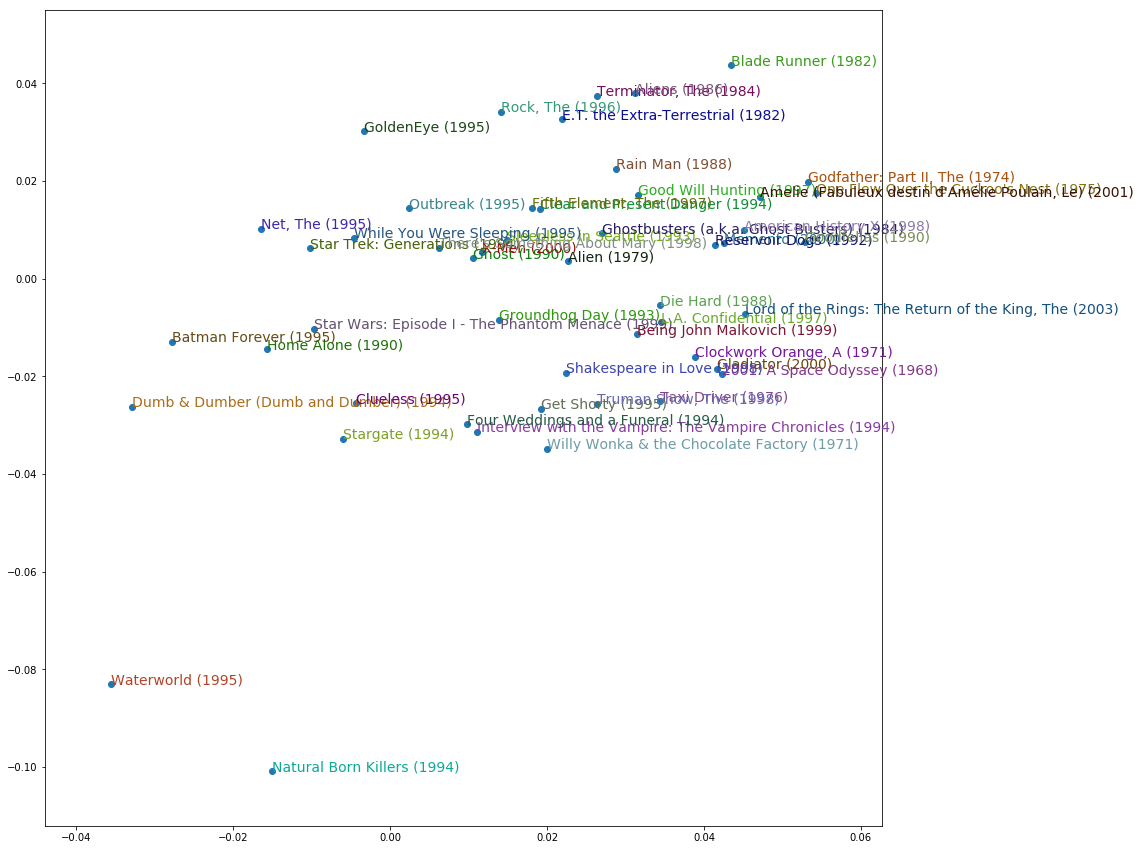

In [122]:
start=50; end=100
X = fac20[start:end]
Y = fac21[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names()[moviesUniq[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

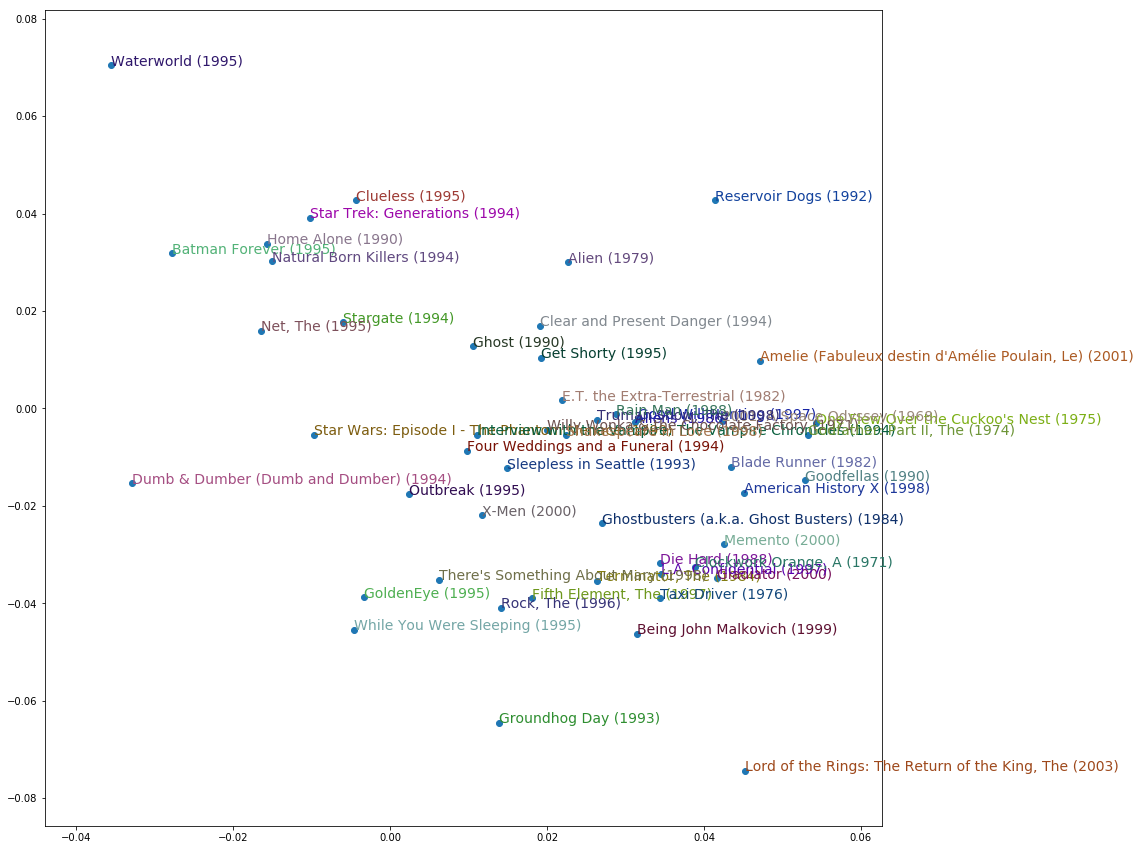

In [123]:
start=50; end=100
X = fac20[start:end]
Y = fac22[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names()[moviesUniq[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

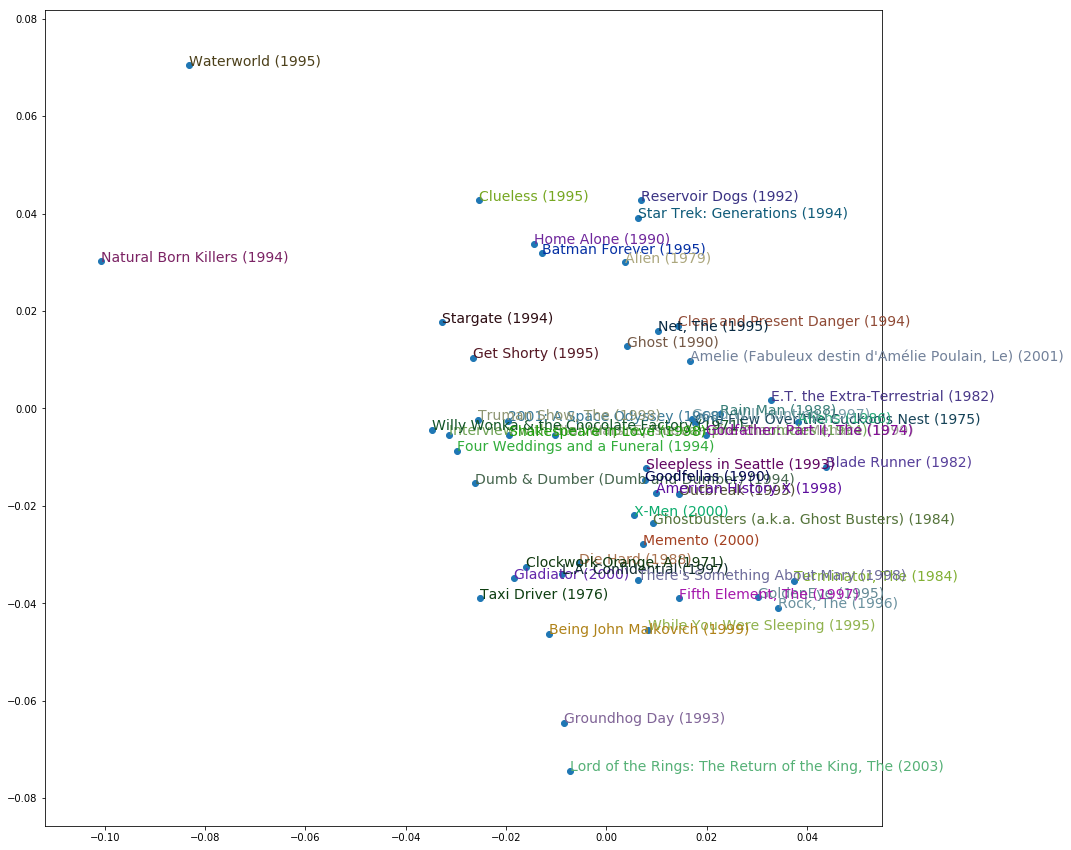

In [124]:
start=50; end=100
X = fac21[start:end]
Y = fac22[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names()[moviesUniq[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()